In [65]:
import torch

In [66]:
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

### Dataset image transfromation

In [67]:
# define transformation for the dataset
transform=transforms.Compose(
   [ transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])]
)

### Loading the dataset

In [68]:
%pwd

'/home/test-14900/Projects/Programming/NLP-and-ML-OPS/Pytorch'

In [69]:
# Load flowers dataset (Assuming it's available in a direction structure)
dataset_path="/home/test-14900/Projects/Programming/Dataset/Flower/dataset/"
train_dataset=torchvision.datasets.ImageFolder(root=dataset_path+"train",transform=transform)
test_dataset=torchvision.datasets.ImageFolder(root=dataset_path+"test",transform=transform)

In [70]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)

### Dataset info

In [71]:
def dataset_info(loader,dataset_name="Dataset"):
    print(f"Dataset:{dataset_name}")
    print(f"Total samples:{len(loader.dataset)}")
    images,labels=next(iter(loader))
    print(f"Batch size: {images.shape[0]}")
    print(f"Image shape:{images.shape}")
    print(f"Unique classes:{set(labels.numpy())}")
    print(f"Total classes: {len(set(labels.numpy()))}")

dataset_info(train_loader,"Training set")
          

Dataset:Training set
Total samples:1275
Batch size: 32
Image shape:torch.Size([32, 3, 224, 224])
Unique classes:{np.int64(0), np.int64(1)}
Total classes: 2


### Model training

In [72]:
if torch.cuda.is_available():
    device="cuda"
else:
    device="cpu"

In [73]:
# def train(num_epochs=10):
#     train_losses,train_accuracies=[],[]
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss,correct,total=0.0,0,0
#         for images,label in train_loader:
#             images,labels=images.to(device),label.to(device)
#             optimizer.zero_grad()
#             output=model(images)
#             loss=criterion(output,labels)
#             loss.backward()
#             optimizer.step()
#             running_loss+=loss.item()
#             _,predicted=outputs.max(1)
#             total+=labels.size(0)
#             correct+=(predicted==labels).sum().item()
#         epoch_loss = running_loss/len(train_loader)
#         epoch_acc=100.*correct/total
#         train_losses.append(epoch_loss)
#         train_accuracies.append(epoch_acc)
#         print(f"Epoch {epoch+1}, Loss: {epoch_loss:0.4f}, accuracy: {epoch_acc:0.2f}")
#         return train_losses,train_accuracies

### AlexNet Model Architecture

In [74]:
class AlexNet(nn.Module):
    def __init__(self,num_classes=2):
        super(AlexNet,self).__init__()
        self.features=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=11,stride=4,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(64,192,kernel_size=5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(192,384,kernel_size=3,padding=1),
            nn.ReLU(inplace=True)
            ,nn.Conv2d(384,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2)
        )
        self.classifier=nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096,num_classes)
        )

    def forward(self,x):
            x=self.features(x)
            x=torch.flatten(x,1)
            x=self.classifier(x)
            return x

### Model, Loss Function, Optimizer

In [75]:
model=AlexNet(num_classes=2).to(device)
criterion=nn.CrossEntropyLoss()
lr=0.01
optimizer=optim.Adam(model.parameters(),lr)

### Model Evaluation

In [76]:
def train(num_epochs):
    train_losses,train_accuracies=[],[]
    for epoch in range(0,200):
        model.train()
        running_loss,correct,total=0.0,0,0
        for images,label in train_loader:
            images,labels=images.to(device),label.to(device)
            optimizer.zero_grad()
            outputs=model(images)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            _,predicted=outputs.max(1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
        epoch_loss = running_loss/len(train_loader)
        epoch_acc=100.*correct/total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        if (epoch+1)%20==0:
         print(f"Epoch {epoch+1}, Loss: {epoch_loss:0.4f}, accuracy: {epoch_acc:0.2f}")
    return train_losses,train_accuracies

In [77]:
def evaluate():
    model.eval()
    correct,total=0,0
    with torch.no_grad():
        for images,labels in test_loader:
            images,labels=images.to(device),labels.to(device)
            outputs=model(images)
            _,predicted=outputs.max(1)
            total+=labels.size(0)
            correct+=predicted.eq(labels).sum().item()
    
    accuracy=100.*correct/total
    print(f"Test Accuracy: {accuracy:0.2f}%")
    return accuracy


### Model Inferencing

In [78]:
def predict(image_path):
    from PIL import Image
    image=Image.open(image_path)
    image=transform(image).unsqueeze(0).to(device)
    model.eval()

    with torch.no_grad():
        output=model(image)
        _,predicted=output.max(1)
    print(f"Predicted class: {predicted.item()}")
    return predicted.item()

### Visualization of Loss and Accuracy

In [79]:
def plot_metrics(train_losses,train_aacuracies):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses,label="Training Losses")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(train_aacuracies,label="Training Accuracy",color="green")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.show()


**************************************************
training started
Epoch 20, Loss: 0.6791, accuracy: 58.51
Epoch 40, Loss: 0.6817, accuracy: 58.51
Epoch 60, Loss: 0.6789, accuracy: 58.51
Epoch 80, Loss: 0.6801, accuracy: 58.51
Epoch 100, Loss: 0.6791, accuracy: 58.51
Epoch 120, Loss: 0.6791, accuracy: 58.51
Epoch 140, Loss: 0.6818, accuracy: 58.51
Epoch 160, Loss: 0.6795, accuracy: 58.51
Epoch 180, Loss: 0.6819, accuracy: 58.51
Epoch 200, Loss: 0.6790, accuracy: 58.51
Train Completed
**************************************************
Model Evaluation Started
Test Accuracy: 57.69%
Model evaluation started
**************************************************
Plotting Metrices


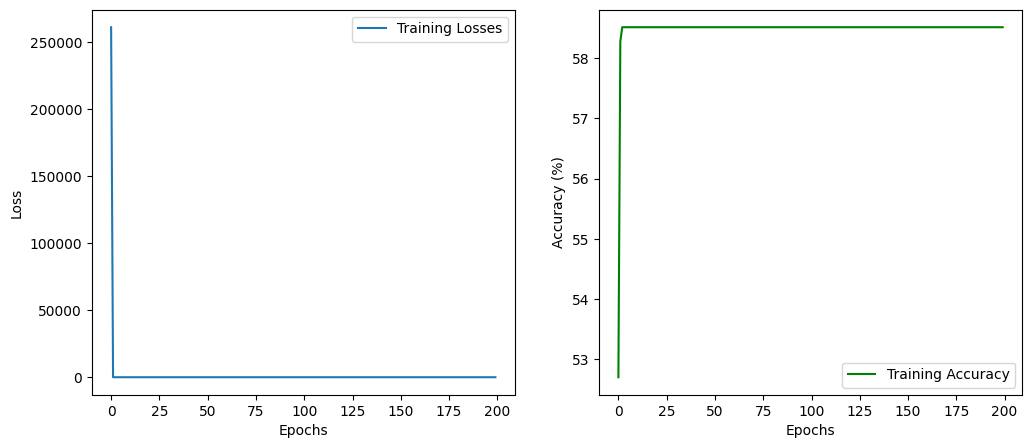

In [80]:
print("*"*50)
print("training started")
train_losses,train_accuracies=train(2000)
# train(200)
print('Train Completed')
print("*"*50)
print("Model Evaluation Started")
evaluate()
print("Model evaluation started")
print("*"*50)
print("Plotting Metrices")
plot_metrics(train_losses,train_accuracies)

In [82]:
torch.save(model,"10 AlexNet Pytorch.pkl")
